In [1]:
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from IPython.display import display
import sys
from statistics import mean
from timeit import default_timer as timer
from numpy import sqrt
from myheatmap import myheatmap
import lmfit

import sympy as sp
sp.init_printing(use_latex ='mathjax')
import math
import scipy as sc
from sklearn.linear_model import LinearRegression
from lmfit import Model

Vivaflag = True

In [2]:
if Vivaflag:
    folder = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\2019\08\09'
else:
    folder = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/2019/08/09/'

import detect_peaks
from detect_peaks import detect_peaks

#sns.set(style='ticks') # makes longer tick marks
sns.set_context('poster') # makes text larger

## Fitting functions
def lowerantifn(x,m1,m2,k,k1):
    k2 = k1+x;
    return sqrt(x/m2 + k/m2 + k1/m2 + k/m1 + k1/m1 - 
                      sqrt(-4*(k*k1 + k*k2 + k1*k2)*m1*m2 + (-k*m1 - k2*m1 - k*m2 - k1*m2)**2)
                      /(m1*m2))/sqrt(2)
def upperantifn(x,m1,m2,k,k1):
    k2 = k1+x;
    return sqrt(x/m2 + k/m2 + k1/m2 + k/m1 + k1/m1 + 
                      sqrt(-4*(k*k1 + k*k2 + k1*k2)*m1*m2 + (-k*m1 - k2*m1 - k*m2 - k1*m2)**2)
                      /(m1*m2))/sqrt(2)
def middle1(x, m1,m2,k,k1):
    return sqrt(x/m2 + k/m2 + k1/m2 + k/m1 + k1/m1)/sqrt(2)

def W(x,A,B,C,D,sigma0, offset=0):
    x = x - offset; # Center does not have to be at zero.
    # Recursive definition of sigma: sigma == sigma0 + D*x**4/sigma^2.
    sigma = (sigma0 + (2**(1/3)*sigma0**2)/(2*sigma0**3 + 27*D*x**4 + 3*sqrt(3)*sqrt(4*D*sigma0**3*x**4 + 27*D**2*x**8))**(1/3) 
             + (2*sigma0**3 + 27*D*x**4 + 3*sqrt(3)*sqrt(4*D*sigma0**3*x**4 + 27*D**2*x**8))**(1/3)/2**(1/3))/3
    W = sqrt(A - B*x**2 + C*x**4/sigma)
    return W

def Wresidual(params, x, data):
    A = params['A']
    B = params['B']
    C = params['C']
    D = params['D']
    sigma0 = params['sigma0']
    offset = params['offset']

    model = W(x,A,B,C,D,sigma0, offset)
    resid = data - model
    return resid
    
def anticrossingresidual(params, x, upperdat, lowerdat):
    m1 = params['m1']
    m2 = params['m2']
    k = params['k'] # coupling spring
    k1 = params['k1']

    model1 = upperantifn(x, m1,m2,k,k1)
    model2 = lowerantifn(x, m1,m2,k,k1)
    
    resid1 = upperdat - model1
    resid2 = lowerdat - model2
    return np.concatenate((resid1, resid2))

def offsetindex(df, offset, indexname):
    dfoffset = df.copy()
    dfoffset.index = df.index- offset
    dfoffset.index.name = indexname
    return dfoffset

ModuleNotFoundError: No module named 'detect_peaks'

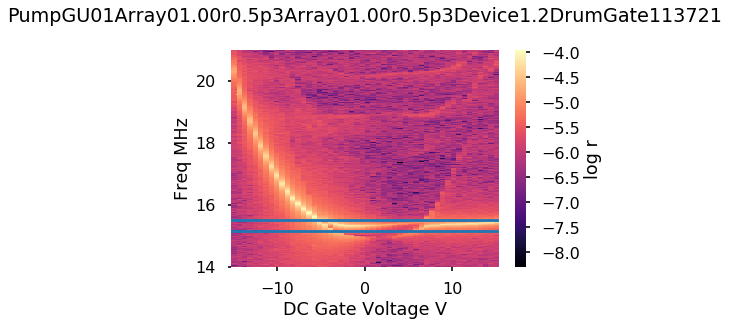

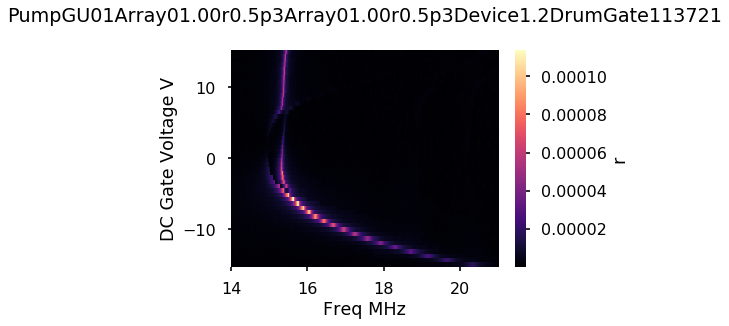

In [46]:
file = 'PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2DrumGate113721' 
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df)  

df['rlog'] = np.log10(df.r) 
df['Freq MHz']=(df.frequency)/10**6
df['Freq MHz']= df['Freq MHz'].round(9)
df['DC Gate Voltage V'] = df['Keithley Voltage'].round(9)

p = df.pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'rlog').sort_index(axis = 0, ascending = False) 
#sns.heatmap(p)

"""
Vpowplot plots rlog versus frequency after calculating the voltage to the power n.
"""
def Vpowplot(df,n, transpose =False,  offset=0, 
             colname = 'Keithley Voltage', nicecolname = 'DC Gate Voltage V', values='rlog', **kwargs):
    if (-1)**n == -1:
        df['('+ nicecolname +')^' + str(n)] = ((df[colname])**n).round(9)
        nthlog = df.pivot_table(index = '('+ nicecolname +')^' + str(n), columns = 'Freq MHz', 
                            values = values).sort_index(axis = 0, ascending = False) 
    else:
        ## Need to explicitly separate positive and negative voltages.
        posdf = df[df[colname]>0]
        negdf = df[df[colname]<0]
        posdf['(' + nicecolname + ')^' + str(n)] = ((posdf[colname])**n).round(9)
        negdf['(' + nicecolname +')^' + str(n)] = -((negdf[colname])**n).round(9)
        posnthlog = posdf.pivot_table(index = '('+ nicecolname +')^' + str(n), columns = 'Freq MHz', 
                            values = values).sort_index(axis = 0, ascending = False) 
        negnthlog = negdf.pivot_table(index = '('+ nicecolname +')^' + str(n), columns = 'Freq MHz', 
                            values = values).sort_index(axis = 0, ascending = False) 
        nthlog = pd.concat([posnthlog,negnthlog])
    if offset:
        nthlog = offsetindex(nthlog, offset, '(Voltage diff)^' + str(n))
    plt.figure()
    if transpose:
        myheatmap(nthlog.transpose(), 'log r',  **kwargs)
    else:
        myheatmap(nthlog, 'log r',  **kwargs)


plt.figure()
ax = myheatmap(p.transpose(),'log r',)
plt.title(file + '\n');
ax.axhline(15.16)
ax.axhline(15.5)

# This is the same heatmap as shown above except it shows r instead of log(r)

plt.figure()
p2 = df.pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False) 
myheatmap(p2, 'r', )
plt.title(file + '\n');

Gate voltage: -3.979493 V


31

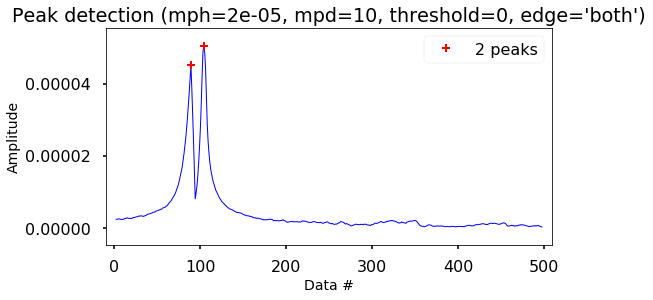

[89, 104]
Float64Index([15.248496994, 15.458917836], dtype='float64', name='Freq MHz')


0.21042084199999955

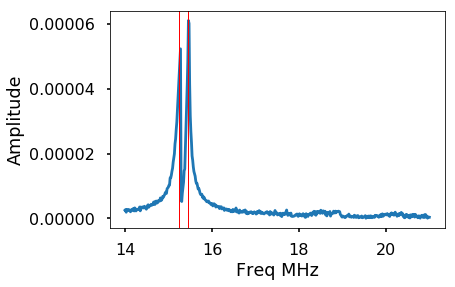

In [47]:
i = 31
if True:
    print("Gate voltage: " + str(p2.iloc[i].name) + " V")
    data = p2.iloc[i]
    display(i)
    ## Manual adjustement
    if True:
        mph = 2e-5;
        #print(mph)
        mpd = 10
    if True:
        window = 5;
    res = detect_peaks(pd.DataFrame.rolling(data, window, center=True).sum()/window, 
             mph=mph, 
             #threshold=1e-9,
             mpd=mpd,
             edge = 'both',
             show=True)
    #print(res)
    if True:
        res = list(res)
    print(res)
    
data.plot()
plt.ylabel('Amplitude')
for j in p2.columns[res[:]]:
    plt.axvline(x=j, color='r', linewidth=1)
print(p2.columns[res[:]])

p2.columns[res[1]] - p2.columns[res[0]]

In [50]:
# initialize peaks list
peaksint = []
freqlist = []

verbose = False


for i in range(len(p2)):
    data = p2.iloc[i]
    if verbose:
        display(i)
        print("Gate voltage: " + str(p2.iloc[i].name) + " V")
    ## Manual adjustement
    if i<33:
        mph = 1.5e-6;
        #print(mph)
        mpd = 10
    else:
        mph = 5e-6;
        mpd = 15;
    if True:
        window = 5;
    res = detect_peaks(pd.DataFrame.rolling(data, window, center=True).sum()/window, 
             mph=mph, 
             #threshold=1e-7,
             mpd=mpd,
             edge = 'both',
             show=verbose)
    #print(res)
    if i==33 or i == 35 or i == 47 or i == 49:
        res = list(res)
    elif i == 34 or (i >= 36 and i <= 40) or i == 42 or i == 44 or i == 46:
        res = list(res[j] for j in [1])
    elif i == 18 or i == 19 or i == 20:
        res = list(res[j] for j in [0,2,3])
    elif i == 0:
        res = list(res[j] for j in [2,5])
    elif i == 1:
        res = list(res[j] for j in [3,5])
    elif i == 2:
        res = list(res[j] for j in [3,6,7]) # not sure about 6 and 7
    elif i == 3:
        res = list(res[j] for j in [4,7])
    elif i == 4:
        res = list(res[j] for j in [2])
    elif i == 5:
        res = list(res[j] for j in [3,6]) #?
    elif i == 6:
        res = list(res[j] for j in [3,7,8,9])
    elif i == 7:
        res = list(res[j] for j in [3,7,8])
    elif i == 8:
        res = list(res[j] for j in [2,8, 9,10]) #8?
    elif i == 9:
        res = list(res[j] for j in [2,7,8,10])
    elif i == 10:
        res = list(res[j] for j in [3,7,8,9])
    elif i == 11:
        res = list(res[j] for j in [2,5,6,7])
    elif i == 12:
        res = list(res[j] for j in [1,2,3,4])
    elif i == 13:
        res = list(res[j] for j in [2,3,4,5])
    elif i == 14:
        res = list(res[j] for j in [1,2,3,4])
    elif i == 15:
        res = list(res[j] for j in [2,3,5,6])
    elif i == 16:
        res = list(res[j] for j in [1,2,4,5])
    elif i == 17:
        res = list(res[j] for j in [1,3,4,5])
    elif i == 22:
        res = list(res[j] for j in [0,2,4])
    elif i == 23:
        res = list(res[j] for j in [1,2,5])
    elif i == 24:
        res = list(res[j] for j in [1,2,5])
    elif i == 25:
        res = list(res[j] for j in [3,4,8])
    elif i == 26:
        res = list(res[j] for j in [3,4,8,9])
    elif i == 27:
        res = list(res[j] for j in [4,5,10,11])
    elif i == 28:
        res = list(res[j] for j in [4,5,13,14])
    elif i == 29:
        res = list(res[j] for j in [4,5,15,16])
    elif i == 30 or i == 31:
        res = list(res[j] for j in [3,4,16])
    elif i == 32:
        res = list(res[j] for j in [4,5,19])
    elif i == 41 or i == 43:
        res = list(res[j] for j in [2])
    elif i == 45 or i == 48:
        res = list(res[j] for j in [0])
    else:
        res = list(res)
    if verbose:
        print(res)


    freqlist.append(p2.columns[res[:]])
    # shorten results to just 2 peaks
    peaksint.append(res[:])
    #print(peaksint[i])
    
if verbose:
    display(peaksint)
    display(freqlist)

peakfreqsp2 = pd.DataFrame(freqlist, index = p2.index)#, columns=["peak1 freq [MHz]", "peak2 freq [MHz]"])

PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2DrumGate113721


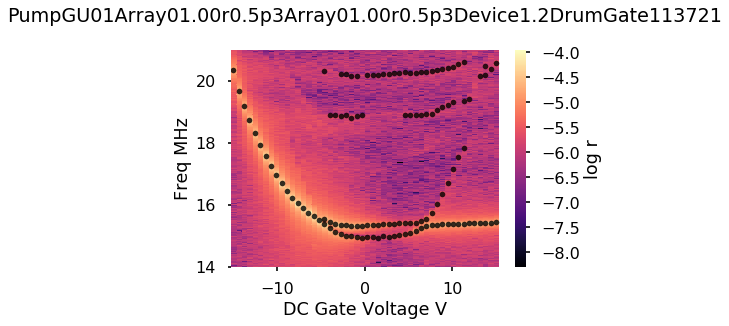

In [51]:
peakfreqsp2.plot(marker='.', color='k', alpha=0.8, linestyle=None, linewidth=0, legend=False)
myheatmap(p.transpose(),'log r')
plt.title(file + '\n');
print(file)

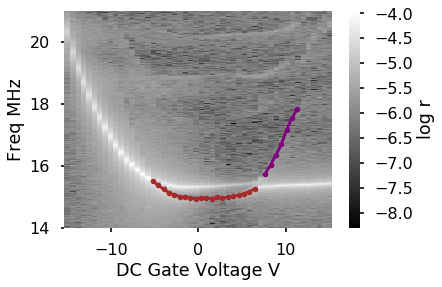

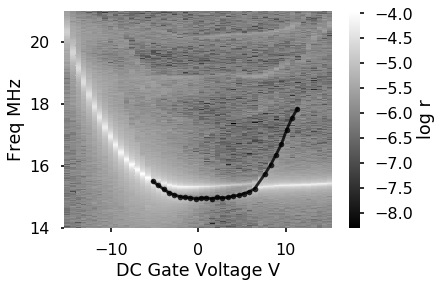

In [52]:
myheatmap(p.transpose(),'log r', cmap = 'gray')

bottomofcurve = peakfreqsp2.iloc[14:34,0]
sideofcurve = peakfreqsp2.iloc[6:13,1]

bottomofcurve.plot(marker ='.', color='brown')
sideofcurve.plot(marker ='.', color = 'purple')

wholecurve = pd.concat([sideofcurve,bottomofcurve])

plt.figure();
myheatmap(p.transpose(),'log r', cmap = 'gray')
wholecurve.plot(marker = '.', color = 'k', alpha = .8) #,linestyle=None, linewidth=0, legend=False)

PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2DrumGate113721



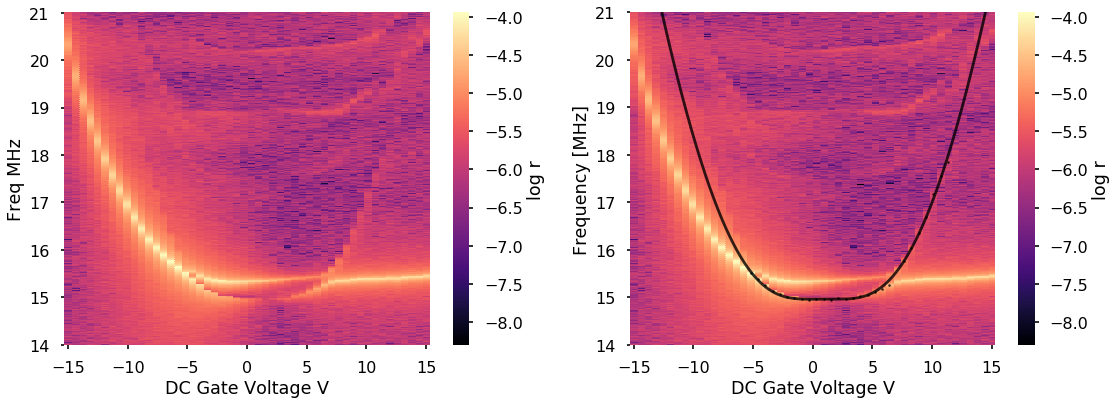

In [54]:

## data to be fit
data=wholecurve.values
x=wholecurve.index.values

## Initial guess for parameters.
params = lmfit.Parameters()
params.add('A', value=100, vary=True)
params.add('B', value=1, vary=True) 
params.add('C', value=1 , vary=True)
params.add('D', value=1, vary=True)
params.add('sigma0', value=1, vary=True)
params.add('offset', value=0, vary=True)

## perform the fit
out = lmfit.minimize(Wresidual, params, args=(x, data),nan_policy='propagate')
display(out) # display all the results

## Plot the fitting result.
V = np.linspace(start=p.index.values.min(), stop=p.index.values.max(), num=1000)
# fit parameters
A = out.params['A'].value  
B = out.params['B'].value  
C = out.params['C'].value  
D = out.params['D'].value  
sigma0 = out.params['sigma0'].value  
offset = out.params['offset'].value  
## display the results
#display(out.params)

##  plot heatmap without and with fit.

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
plt.sca(ax1)
myheatmap(p.transpose(),'log r')

plt.sca(ax2)
myheatmap(p.transpose(),'log r')
wholecurve.plot( marker = '.', markersize=5, color='k',linestyle= 'None', legend=False, alpha = .8)
plt.ylabel("Frequency [MHz]")
plt.plot(V,W(V,A,B,C,D,sigma0, offset), 'k', alpha = .8)
plt.ylim(ymax=21.)

plt.tight_layout()

print(file + '\n')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


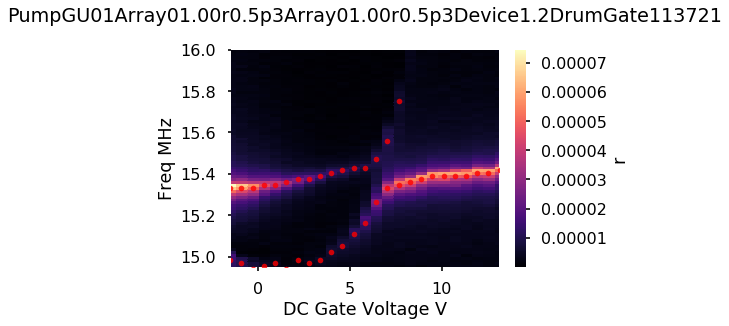

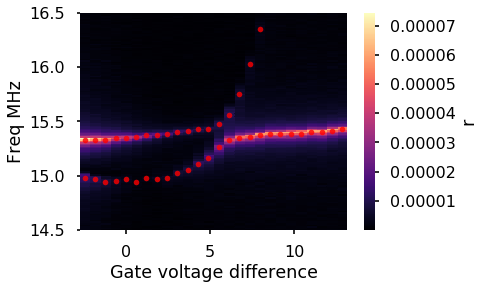

In [55]:
minfreq = 14.5
maxfreq = 16.5
minV = -2
maxV = 14.1
lf = df['Freq MHz'] > minfreq 
hf = df['Freq MHz'] < maxfreq
lv = df['DC Gate Voltage V'] > minV
hv = df['DC Gate Voltage V'] < maxV
n = df[lf][hf][lv][hv].pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False)
myheatmap(n.transpose(), 'r')
ax = plt.gca()
plt.title(file + '\n');
peakfreqsp2.plot(marker='.', color='r', alpha=0.8, linestyle=None, linewidth=0, legend=False, ax=ax)
plt.xlim(-1.5,13.1)
plt.ylim(14.95,16);


noffset = offsetindex(n,offset,'Gate voltage difference')
peakfreqsp2offset=offsetindex(peakfreqsp2,offset,'Gate voltage difference')

plt.figure()
myheatmap(noffset.transpose(), 'r')
xlimits = plt.xlim()  # return the current xlim
ylimits = plt.ylim()  # return the current ylim
ax = plt.gca()
peakfreqsp2offset.plot(marker='.', color='r', alpha=0.8, linestyle=None, linewidth=0, legend=False, ax=ax )
plt.xlim(xlimits)   # set the xlim to left, right
plt.ylim(ylimits)   # set the ylim to left, right

pospeakfreqsp2 = peakfreqsp2[peakfreqsp2.index>0]
pospeakfreqsp2offset = peakfreqsp2offset[peakfreqsp2offset.index>0]



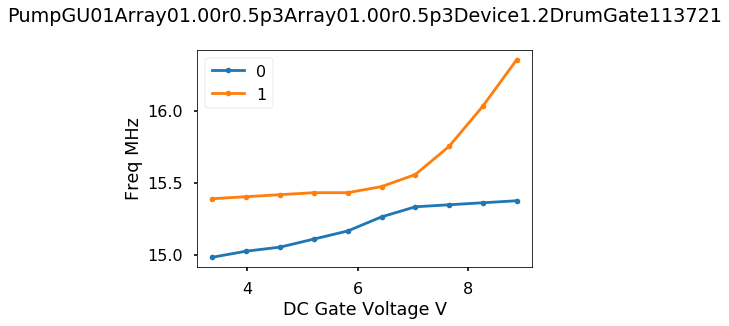

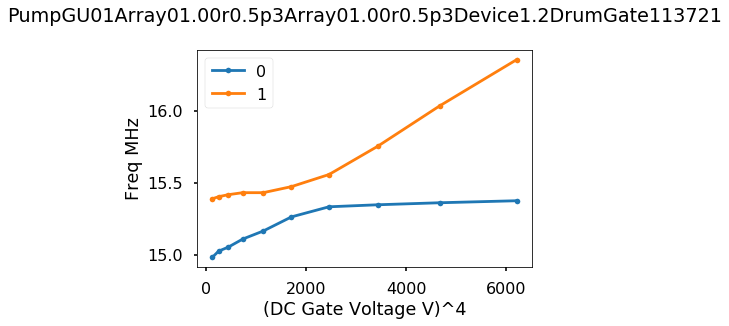

In [56]:
minV = 3
maxV = 9
lf = pospeakfreqsp2 > minfreq 
hf = pospeakfreqsp2 < maxfreq
lv = pospeakfreqsp2.index > minV
hv = pospeakfreqsp2.index < maxV

zoomedpeakfreqsp2 = (pospeakfreqsp2[lf][hf][hv]).iloc[:,0:2]
lv = zoomedpeakfreqsp2.index > minV
zoomedpeakfreqsp2 = zoomedpeakfreqsp2[lv]

zoomedpeakfreqsp2.plot(marker ='.')
plt.title(file + '\n');
plt.ylabel('Freq MHz')

pow4zoomedpeakfreqsp2 = zoomedpeakfreqsp2.copy()
pow4zoomedpeakfreqsp2.index = zoomedpeakfreqsp2.index**4
pow4zoomedpeakfreqsp2.index.name = '(DC Gate Voltage V)^4'


pow4zoomedpeakfreqsp2.plot(marker ='.')
plt.title(file + '\n');
plt.ylabel('Freq MHz');

array([16.35671343, 16.03406814, 15.75350701, 15.55711423, 15.47294589,
       15.43086172, 15.43086172, 15.41683367, 15.40280561, 15.38877756])

array([15.3747495 , 15.36072144, 15.34669339, 15.33266533, 15.26252505,
       15.16432866, 15.10821643, 15.05210421, 15.0240481 , 14.98196393])

array([6210.46019373, 4667.00729046, 3430.35714314, 2457.87800039,
       1707.76372236, 1144.57024036,  733.48664916,  444.68428175,
        250.78918134,  128.60084731])

(14.497995992000002, 16.5)

<Figure size 432x288 with 0 Axes>

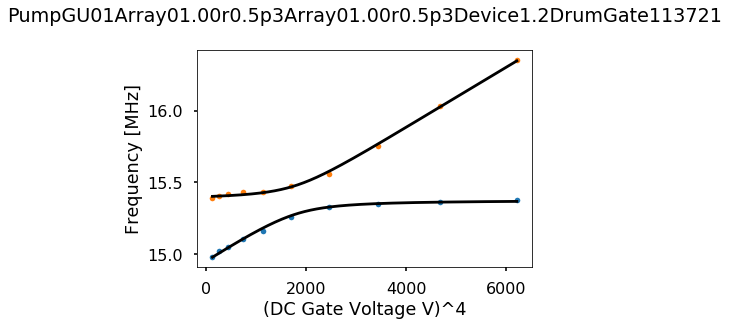

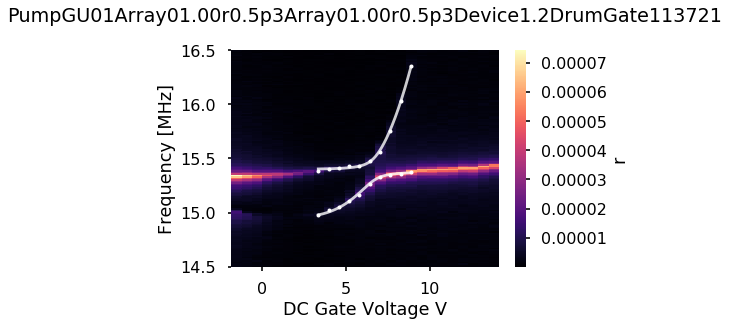

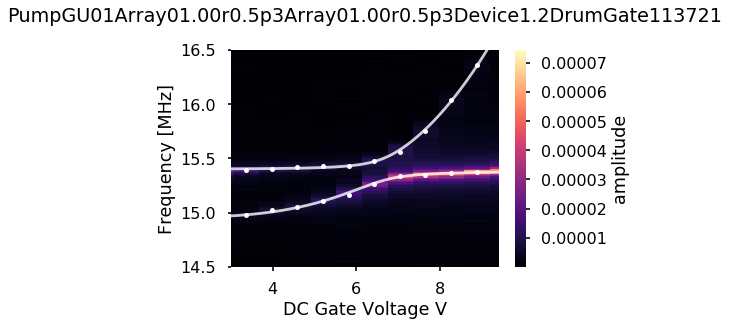

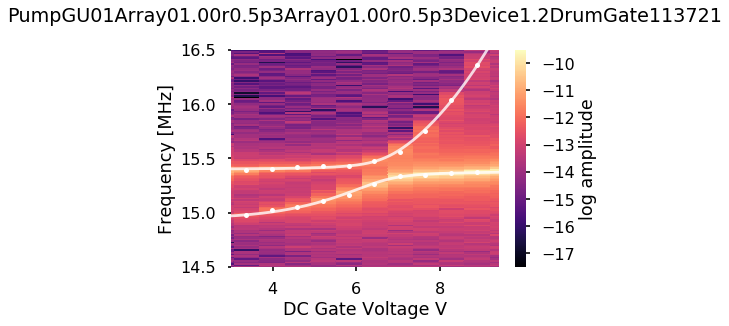

In [57]:
#upperantim = lmfit.Model(upperantifn)
#lowerantim = lmfit.Model(lowerantifn)

# input guesses for the fitting parameters
params2 = lmfit.Parameters()
params2.add('k1', value=10, vary=True)
params2.add('m1', value=.15, vary=True) 
params2.add('m2', value=20 , vary=True)
params2.add('k', value=0.1, vary=True, min=0)

"""## plot the data
myheatmap((pow4zoomedpeakfreqsp2).transpose(), cmap = 'gray') # cutting out last row because it is incomplete
pow4zoomedpeakfreqsp2.plot( marker = '.',  linestyle= 'None', legend=True)
plt.title(file + '\n');"""

## data to be fit
dat1=pow4zoomedpeakfreqsp2.iloc[:,1].values
dat2=pow4zoomedpeakfreqsp2.iloc[:,0].values
x=pow4zoomedpeakfreqsp2.index.values

display(dat1)
display(dat2)
display(x)

## perform the fit
out = lmfit.minimize(anticrossingresidual, params2, args=(x, dat1, dat2),nan_policy='propagate')
display(out) # display all the results

## Plot the fitting result.
dk = np.linspace(pow4zoomedpeakfreqsp2.index.values.min(), pow4zoomedpeakfreqsp2.index.values.max(), 500)
# fit parameters
k1 = out.params['k1'].value   # lower is curvier, higher is larger values and straighter. higher also moves the crossing to the right.
m1 = out.params['m1'].value    # lower moves the crossing to the right, higher moves the crossing to the left
m2 = out.params['m2'].value    # lower moves the crossing to the left, higher moves the crossing to the right
            # if both masses get lower, the crossing gets higher
k = out.params['k'].value;     # higher makes the anti-crossing wider, lower makes the anti-crossing closer.

## display the results
#display(out.params)


##  plot without heatmap
plt.figure();
pow4zoomedpeakfreqsp2.plot( marker = '.', linestyle= 'None', legend=False)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), 'k')
plt.plot(dk,upperantifn(dk, m1,m2,k,k1), 'k')




plt.figure()
ax = myheatmap(n.transpose(), 'r')
zoomedpeakfreqsp2.plot(color='white', marker = '.',markersize=8, linestyle= 'None', legend=False, ax=ax)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
#del m1,m2,k,k1,dk

plt.figure()
dk = np.linspace(0, pow4zoomedpeakfreqsp2.index.values.max()+2000, 500)
ax = myheatmap((n.transpose()), 'amplitude')#, cmap = 'Seismic')
zoomedpeakfreqsp2.plot(color='white', marker = '.',markersize=10, linestyle= 'None', legend=False, ax=ax)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.xlim(3,9.4)
plt.ylim(ymax=16.5)

plt.figure()
ax = myheatmap(np.log(n.transpose()), 'log amplitude')#, cmap = 'Seismic')
zoomedpeakfreqsp2.plot(color='white', marker = '.',markersize=10, linestyle= 'None', legend=False, ax=ax)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.xlim(3,9.4)
plt.ylim(ymax=16.5)



PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2DrumGate113721


(14.497995992000002, 16.504008016)

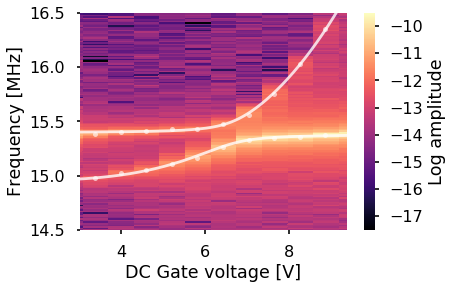

In [58]:
## considering variations on the plot

normconst = n.max().max()
color = 'w'
data = np.log(n)
ax = myheatmap(((data).transpose()), 'Log amplitude',cmap='magma')#, cmap = 'Seismic')
zoomedpeakfreqsp2.plot(color=color, alpha = .6, marker = '.', markersize=10, 
                       linestyle= 'None', linewidth=0.5, legend=False, ax=ax)
ylims = plt.ylim()
plt.ylabel("Frequency [MHz]")
plt.xlabel("DC Gate voltage [V]")
print(file)
plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1), color=color, alpha = .8)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), color=color, alpha = .8)
plt.xlim(3,9.4)
plt.ylim(ylims)

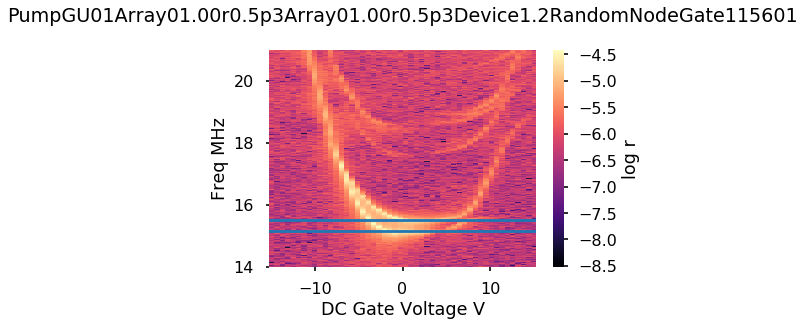

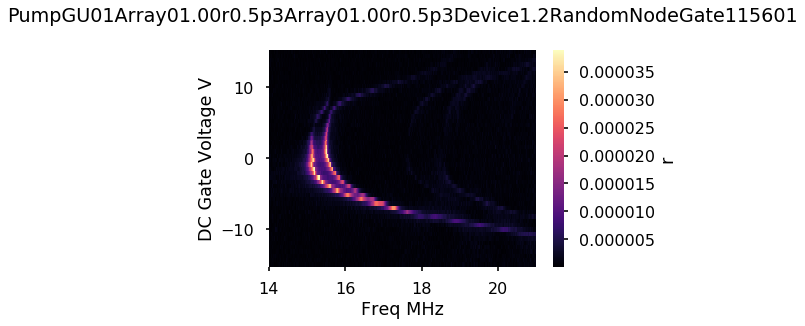

In [59]:
file = 'PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2RandomNodeGate115601'
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df)

df['rlog'] = np.log10(df.r) 
df['Freq MHz']=(df.frequency)/10**6
df['Freq MHz']= df['Freq MHz'].round(9)
df['DC Gate Voltage V'] = df['Keithley Voltage'].round(9)
p = df.pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'rlog').sort_index(axis = 0, ascending = False) 
p3 = df.pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False) 
ax = myheatmap(p.transpose(), 'log r')
ax.axhline(15.16)
ax.axhline(15.5)
plt.title(file + '\n');
plt.figure()
myheatmap(p3, 'r')
plt.title(file + '\n');

In [60]:
# initialize peaks list
peaksint = []
freqlist = []

verbose = False

for i in range(len(p3)):
    data = p3.iloc[i]
    if verbose:
        display(i)
        print("Gate voltage: " + str(p3.iloc[i].name) + " V")
    ## Manual adjustement
    if i <= 3:
        mph = 1e-6
        mpd = 8
    elif i == 7:
        mph = 2e-6
        mpd = 10
    elif i == 8:
        mph = 1e-6
        mpd = 10
    elif i == 32:
        mph = 2e-6
        mpd = 20
    elif i == 34:
        mph = 2e-6
        mpd = 8
    elif i == 38:
        mph = 2e-6
        mpd = 10
    elif i == 35:
        mph = 4e-6
        mpd = 7
    elif i >=43:
        mph = .8*data.max();
        print(mph)
        mpd = 10
    elif i >= 36:
        mph = 3e-6
        mpd = 10
    else:
        mph = 1.5e-6
        mpd = 10
    if i == 35:
        window = 1
    else:
        window = 5;
    res = detect_peaks(pd.DataFrame.rolling(data, window, center=True).sum()/window, 
             mph=mph, 
           #  threshold=1e-8,
             mpd=mpd,
             edge = 'both',
             show=verbose)
    if verbose:
        print(res)
    ## seriously manually selected for this dataset
    if i ==27 or i == 28 or i ==29:
        res = list(res[j] for j in [2,4,5,6,7])
    elif i == 3:
        res = list(res[j] for j in [1,3,4,5,6])
    elif i == 4:
        res = list(res[j] for j in [0,1,2,4,6])
    elif i == 5:
        res = list(res[j] for j in [0,1,2,4,5,6])
    elif i == 8:
        res = list(res[j] for j in [0,2,4,5,7,8,14])
    elif i == 11:
        res = list(res[j] for j in [0,1,3,4,5])
    elif i == 12:
        res = list(res[j] for j in [0,1,3,4])
    elif i == 13:
        res = list(res[j] for j in [1,2,3,4,5])
    elif i == 18 or i==20:
        res = list(res[j] for j in [0,1])
    elif i==19 or i == 21 or i == 37:
        res = list(res[j] for j in [0,2] )
    elif i == 22:
        res = list(res[j] for j in [1,2])
    elif i == 25:
        res = list(res[j] for j in [1,2,3])
    elif i == 26:
        res = list(res[j] for j in [1,3,4])
    elif i == 30:
        res = list(res[j] for j in [1,3,4,5,6])
    elif i == 31:
        res = list(res[j] for j in [2,4,5,6,7])
    elif i == 32 or i == 16:
        res = list(res[j] for j in [1,2,3,4])
    elif i == 33:
        res = list(res[j] for j in [2,3,4,6])
    elif i == 34:
        res = list(res[j] for j in [2,3,4])
    elif i ==35:
        res = list(res[j] for j in [3,4,5] )
    elif i ==38:
        res = list(res[j] for j in [0,1,2,3,6] )
    elif i ==39:
        res = list(res[j] for j in [0,2] )
    elif i ==40 or i == 41:
        res = list(res[j] for j in [1] )
    elif i ==42:
        res = list(res[j] for j in [1,2] )
    else:
        res = list(res)
    if verbose:
        print(res)


    freqlist.append(p3.columns[res[:]])
    # shorten results to just 2 peaks
    peaksint.append(res[:])
    #print(peaksint[i])
    
if verbose:
    display(peaksint)
    display(freqlist)

peakfreqsp3 = pd.DataFrame(freqlist, index = p3.index)#, columns=["peak1 freq [MHz]", "peak2 freq [MHz]"])

2.368e-06
1.8544000000000002e-06
1.7032e-06
1.604e-06
1.3304000000000002e-06
1.3464000000000001e-06
1.2432000000000002e-06


PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2RandomNodeGate115601


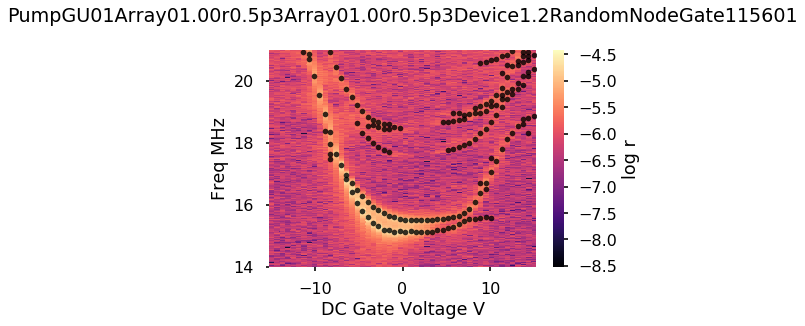

In [61]:
peakfreqsp3.plot(marker='.', color='k', alpha=0.8, linestyle=None, linewidth=0, legend=False)
myheatmap(p.transpose(),'log r')
plt.title(file + '\n');
print(file)

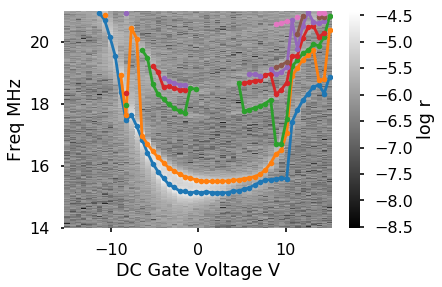

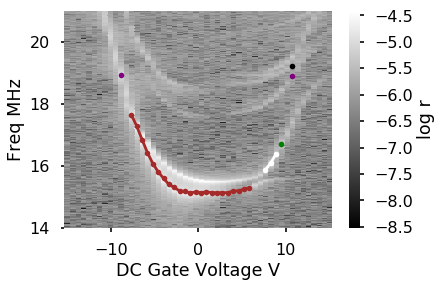

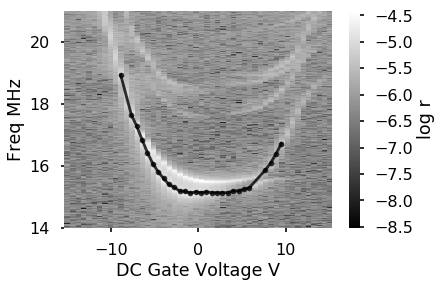

In [62]:
ax = myheatmap(p.transpose(),'log r', cmap = 'gray')
peakfreqsp3.plot(marker ='.', ax=ax, legend=False) 

plt.figure()
myheatmap(p.transpose(),'log r', cmap = 'gray')

leftofcurve = peakfreqsp3.iloc[39:41,1]
bottomofcurve = peakfreqsp3.iloc[15:38,0]
sideofcurve = peakfreqsp3.iloc[7:8,1]
sideofcurve3 = peakfreqsp3.iloc[10:13,1]
sideofcurve2 = peakfreqsp3.iloc[9:10,2]
sideofcurve4 = peakfreqsp3.iloc[7:8,2]



leftofcurve.plot(marker ='.', color='purple')
bottomofcurve.plot(marker ='.', color='brown')
sideofcurve.plot(marker ='.', color = 'purple')
sideofcurve3.plot(marker ='.', color = 'white')
sideofcurve2.plot(marker ='.', color = 'green')
sideofcurve4.plot(marker ='.', color = 'k')


#wholecurve = pd.concat([sideofcurve4,sideofcurve,sideofcurve2,sideofcurve3,bottomofcurve,leftofcurve])
wholecurve = pd.concat([sideofcurve2,sideofcurve3,bottomofcurve,leftofcurve])

wholecurve = wholecurve.dropna()
#display(wholecurve)


plt.figure();
myheatmap(p.transpose(),'log r', cmap = 'gray')
wholecurve.plot(marker = '.', color = 'k', alpha = .8) #,linestyle=None, linewidth=0, legend=False)

PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2RandomNodeGate115601



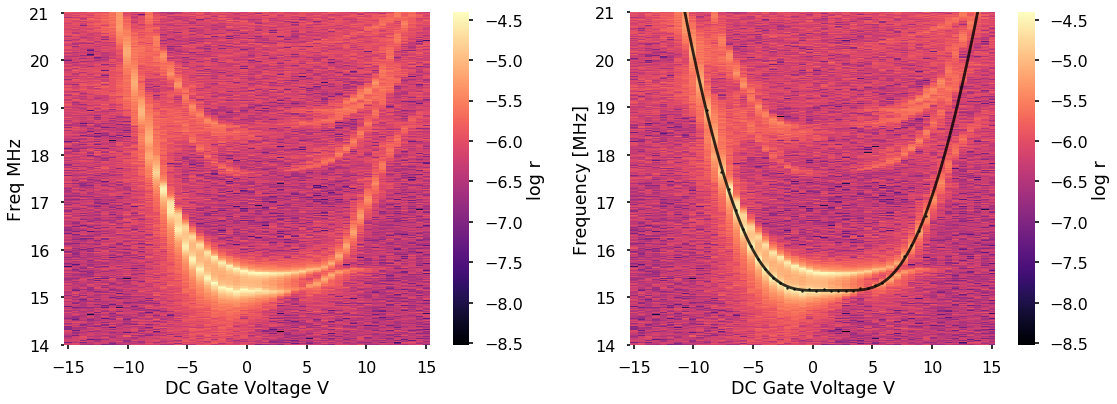

In [63]:

## data to be fit
data=wholecurve.values
x=wholecurve.index.values

## Initial guess for parameters.
params = lmfit.Parameters()
params.add('A', value=230, vary=True)
params.add('B', value=.5, vary=True) 
params.add('C', value=.5 , vary=True)
params.add('D', value=4, vary=True)
params.add('sigma0', value=2, vary=True)#, min=0)
params.add('offset', value=1.557, vary=True)

## perform the fit
out = lmfit.minimize(Wresidual, params, args=(x, data),nan_policy='propagate')
display(out) # display all the results

## Plot the fitting result.
V = np.linspace(start=p.index.values.min(), stop=p.index.values.max(), num=1000)
# fit parameters
A = out.params['A'].value  
B = out.params['B'].value  
C = out.params['C'].value  
D = out.params['D'].value  
sigma0 = out.params['sigma0'].value  
offset = out.params['offset'].value  



## display the results
#display(out.params)


##  plot heatmap without and with fit.

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
plt.sca(ax1)
myheatmap(p.transpose(),'log r')

plt.sca(ax2)
myheatmap(p.transpose(),'log r') 
wholecurve.plot( marker = '.', markersize=5, color='k',linestyle= 'None', legend=False, alpha = .8)
plt.ylabel("Frequency [MHz]")
plt.plot(V,W(V,A,B,C,D,sigma0, offset), 'k', alpha = .8)
plt.ylim(ymax=21.)

plt.tight_layout()

print(file + '\n')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


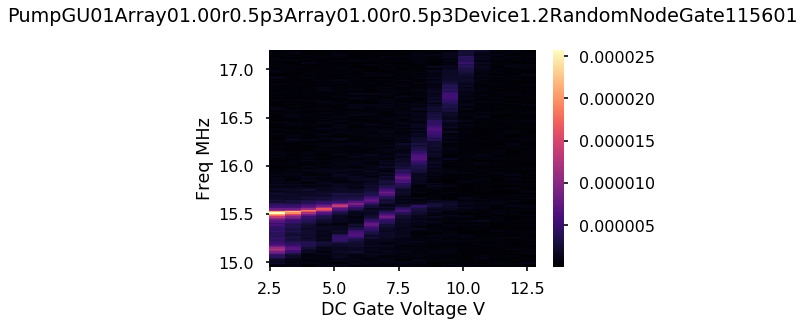

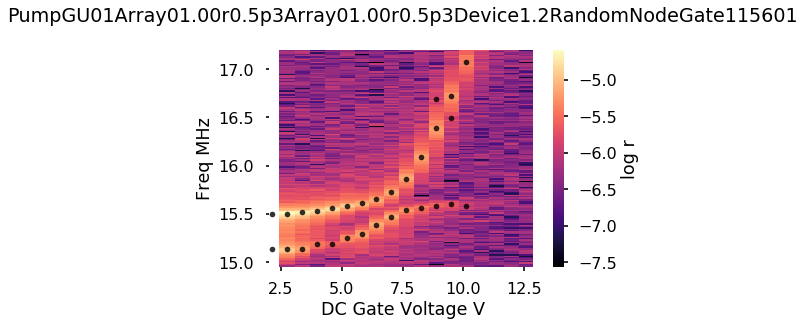

In [64]:
minvoltagep3 = 2.5
maxvoltagep3 = 13.1
lf = df['Freq MHz'] > 14.95 
hf = df['Freq MHz'] < 17.2
lv = df['DC Gate Voltage V'] > minvoltagep3
hv = df['DC Gate Voltage V'] < maxvoltagep3
n = df[lf][hf][lv][hv].pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False)
nlog = df[lf][hf][lv][hv].pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'rlog').sort_index(axis = 0, ascending = False)
myheatmap(n.transpose(), )
plt.title(file + '\n');

plt.figure();
myheatmap(nlog.transpose(), 'log r',)
ax = plt.gca()
peakfreqsp3.plot(marker='.', ax=ax, color='k', alpha=0.8, linestyle=None, linewidth=0, legend=False)
plt.xlim(2., 13.)
plt.ylim(14.95,17.2);
plt.title(file + '\n');

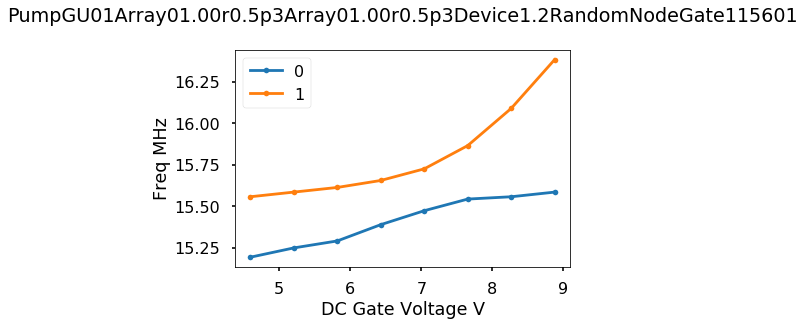

<Figure size 432x288 with 0 Axes>

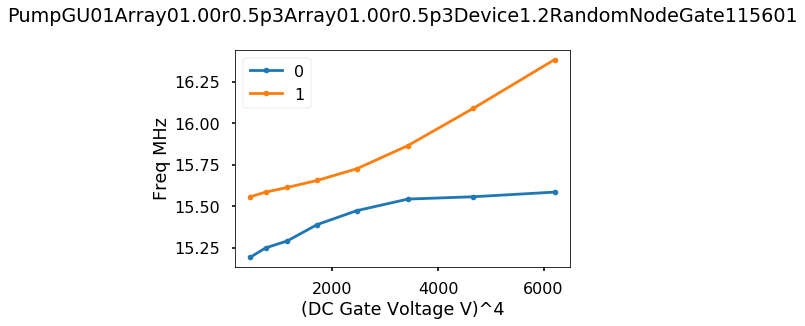

In [65]:
# Select the subset of the data for fitting.
peakfreqsp3fitset = ((peakfreqsp3[peakfreqsp3 < 17])[peakfreqsp3 > 15]).iloc[:,0:2].iloc[10:18]
# plot it.
peakfreqsp3fitset.plot(marker='.')
plt.ylabel('Freq MHz')
plt.title(file + '\n');
peakfreqsp3fitset

pow4peakfreqsp3fitset = peakfreqsp3fitset.copy()
pow4peakfreqsp3fitset.index = peakfreqsp3fitset.index**4
pow4peakfreqsp3fitset.index.name = '(DC Gate Voltage V)^4'

plt.figure()
pow4peakfreqsp3fitset.plot(marker ='.')
plt.title(file + '\n');
plt.ylabel('Freq MHz');

array([16.38476954, 16.09018036, 15.86573146, 15.7254509 , 15.65531062,
       15.61322645, 15.58517034, 15.55711423])

array([15.58517034, 15.55711423, 15.54308617, 15.47294589, 15.38877756,
       15.29058116, 15.24849699, 15.19238477])

array([6210.48537896, 4666.9892217 , 3430.34817848, 2457.87939669,
       1707.75947186, 1144.57260173,  733.48777671,  444.69086666])

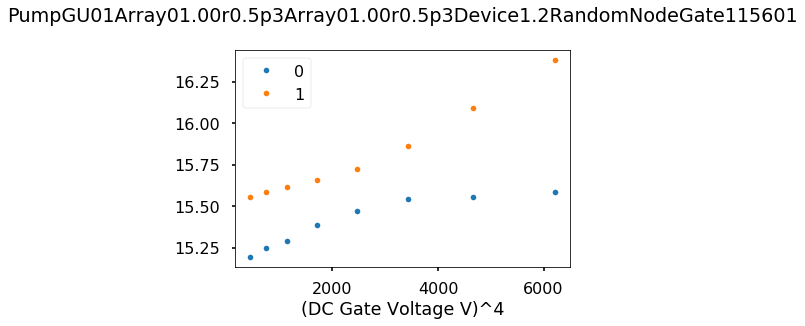

<Figure size 432x288 with 0 Axes>

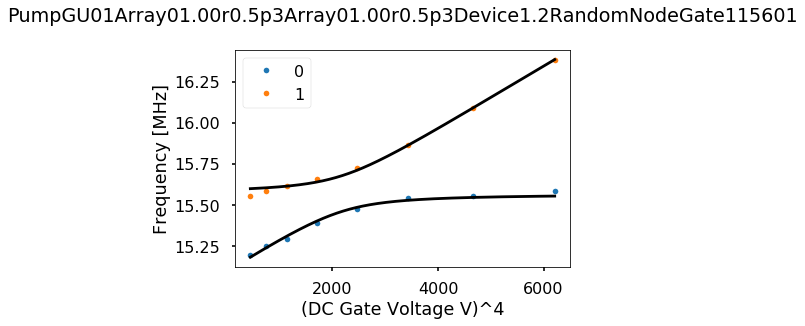

In [66]:
#upperantim = lmfit.Model(upperantifn)
#lowerantim = lmfit.Model(lowerantifn)

# input guesses for the fitting parameters
params2 = lmfit.Parameters()
params2.add('k1', value=30, vary=True)
params2.add('m1', value=.15, vary=True) 
params2.add('m2', value=.15 , vary=True)
params2.add('k', value=1, vary=True, min=0)

## plot the data
#ax = myheatmap((pow4peakfreqsp3fitset).transpose(), cmap = 'gray') # cutting out last row because it is incomplete
pow4peakfreqsp3fitset.plot( marker = '.',  linestyle= 'None', legend=True)
plt.title(file + '\n');

## data to be fit
dat1=pow4peakfreqsp3fitset.iloc[:,1].values
dat2=pow4peakfreqsp3fitset.iloc[:,0].values
x=pow4peakfreqsp3fitset.index.values

display(dat1)
display(dat2)
display(x)

## perform the fit
out = lmfit.minimize(anticrossingresidual, params2, args=(x, dat1, dat2),nan_policy='propagate')
display(out) # display all the results

## Plot the fitting result.
dk = np.linspace(pow4peakfreqsp3fitset.index.values.min(), pow4peakfreqsp3fitset.index.values.max(), 1000)
# fit parameters
k1 = out.params['k1'].value   # lower is curvier, higher is larger values and straighter. higher also moves the crossing to the right.
m1 = out.params['m1'].value    # lower moves the crossing to the right, higher moves the crossing to the left
m2 = out.params['m2'].value    # lower moves the crossing to the left, higher moves the crossing to the right
            # if both masses get lower, the crossing gets higher
k = out.params['k'].value;     # higher makes the anti-crossing wider, lower makes the anti-crossing closer.

## display the results
#display(out.params)


##  plot without heatmap
plt.figure();
pow4peakfreqsp3fitset.plot( marker = '.', linestyle= 'None', legend=True)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), 'k')
plt.plot(dk,upperantifn(dk, m1,m2,k,k1), 'k')


#del m1,m2,k,k1,dk

(5, 9.8)

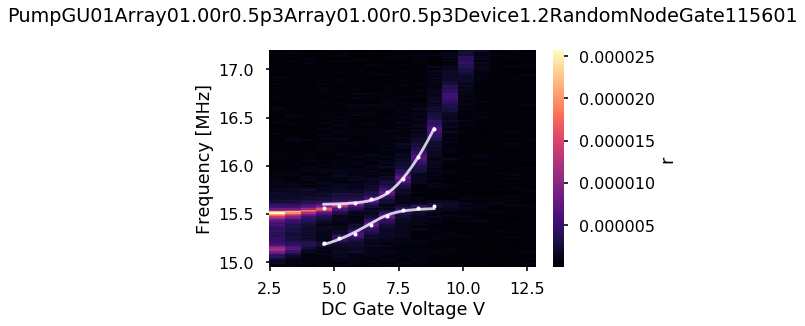

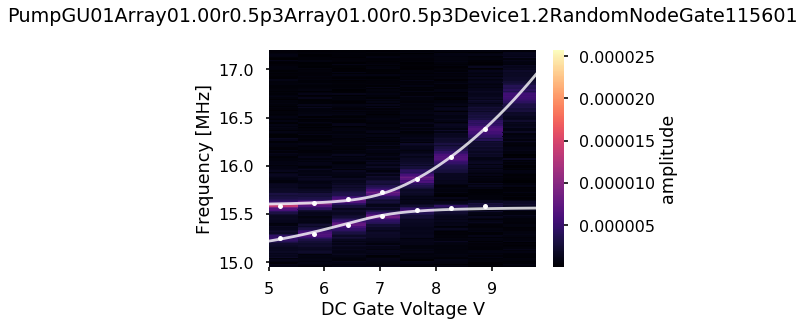

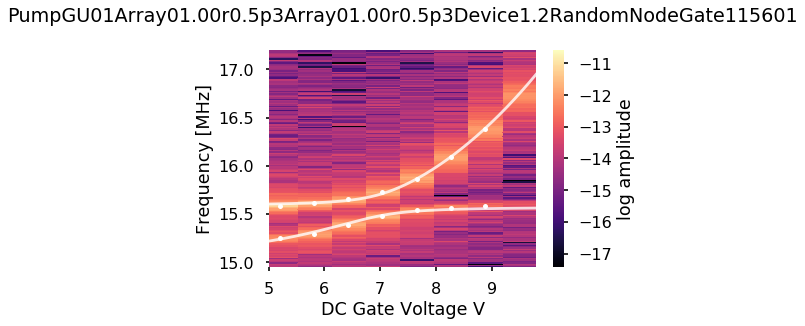

In [67]:

plt.figure()
ax = myheatmap(n.transpose(), 'r')
peakfreqsp3fitset.plot(color='white', marker = '.',markersize=8, linestyle= 'None', legend=False, ax=ax)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
#del m1,m2,k,k1,dk

plt.figure()
dk = np.linspace(0, pow4peakfreqsp3fitset.index.values.max()+3000, 500)
ax = myheatmap((n.transpose()), 'amplitude')#, cmap = 'Seismic')
peakfreqsp3fitset.plot(color='white', marker = '.',markersize=10, linestyle= 'None', legend=False, ax=ax)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.xlim(5,9.8)
#plt.ylim(ymax=16.5)

plt.figure()
ax = myheatmap(np.log(n.transpose()), 'log amplitude')#, cmap = 'Seismic')
peakfreqsp3fitset.plot(color='white', marker = '.',markersize=10, linestyle= 'None', legend=False, ax=ax)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), 'white', alpha = .8)
plt.xlim(5,9.8)
#plt.ylim(ymax=16.5)



In [78]:
#Define column names and read csv file

base1 = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/ResonanceCurves/'
file1 = 'Array01.00r0.5p3Device1.2Drum1Couping500/Data.csv'

base2 = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/ResonanceCurves/'
file2 = 'Array01.00r0.5p3Device1.2RandomNodeCoupling500/Data.csv'

path1 = os.path.join(base1, file1)
path2 = os.path.join(base2, file2)

colnames= ['SweepVal', 'F', 'R', 'theta', 'NEP_BW', 'R_ref', 'theta_ref', 'Amp', 'Phase']

df1 = pd.read_csv(path1, names = colnames)
df2 = pd.read_csv(path2, names = colnames)

In [79]:
#Fit linear part of phase lag to subtract from graph

#Define normalized data for fitting
maxR1 = df1['R'].max()
df1['Rnorm'] = (df1.R) / (maxR1)
df1['Fnorm'] = df1.F / 10**6
df1['Rnorm2']= ((df1.R)/maxR1)**2

df2['Rnorm'] = (df2.R) / (maxR1)
df2['Fnorm'] = df2.F / 10**6
df2['Rnorm2']= ((df2.R)/maxR1)**2

#Definte linear portion of less than 15MHz for fit
mk = df1.Fnorm < 15

x1 = df1[['Fnorm']][mk]
y1 = df1.theta[mk]

x2 = df2[['Fnorm']][mk]
y2 = df2.theta[mk]

#Perform linear fit
model1 = LinearRegression().fit(x1,y1)
r_sq1 = model1.score(x1,y1)

model2 = LinearRegression().fit(x2,y2)
r_sq2 = model2.score(x2,y2)

df1['thetaLin'] = df1.theta - model2.intercept_ - model2.coef_ * df2.Fnorm
df1['radLin'] = df1.thetaLin * np.pi / 180
df1['wrap'] = np.unwrap(df1.radLin)

df2['thetaLin'] = df2.theta - model2.intercept_ - model2.coef_ * df2.Fnorm
df2['radLin'] = df2.thetaLin * np.pi / 180
df2['wrap'] = np.unwrap(df2.radLin)

In [80]:
#Define all variables

#individual springs that correspond to individual masses
#k1, k2 = (0.0063, 0.0063)
k1 = (0.0063)
k2 = sp.symbols('k_2')

#springs that connect two masses
#k12 = 6*10**-6
k12 = sp.symbols('k_12')

#damping coefficients and forc
g1, g2 = (5*10**4,5*10**4)
 
#masses
#m1, m2 = (2.7*10**-17, 2.725*10**-17)
#m1, m2 = sp.symbols('m_1, m_2')
m1 = 2.7*10**-17
m2 = sp.symbols('m_2')

#Driving force amplitude
F = (3*10**-5)

#driving frequency (leave as variable)
wd = sp.symbols('\omega_d')

In [81]:
#Solve for driving amplitudes and phase

#Matrix for complex equations of motion
driven = sp.Matrix([[-wd**2 + 1j*wd*g1 + (k1/m1) + (k12/m1), -k12/m1], [-k12/m2, -wd**2 + 
  1j*wd*g2 + (k2/m2) + (k12/m2)]])

#Matrices for Cramer's Rule
driven_m1 = sp.Matrix([[F/m1, -k12/m1], [0, -wd**2 + 
  1j*wd*g2 + (k2/m2) + (k12/m2)]])

driven_m2 = sp.Matrix([[-wd**2 + 1j*wd*g1 + (k1/m1) + (k12/m1), F/m1], [-k12/m2, 0]])

#Apply Cramer's Rule
Cr1, Cr2 = (driven_m1.det()/driven.det(),driven_m2.det()/driven.det())

#Solve for phases for each mass
delta1 = sp.arg(Cr1)
delta2 = sp.arg(Cr2)

#Wrap phases for plots

wrap1 = (delta1)%(2*np.pi)
wrap2 = (delta2)%(2*np.pi)

#Solve for amplitude coefficients
amp1 = sp.re(Cr1)/sp.cos(delta1)
amp2 = sp.re(Cr2)/sp.cos(delta2)

In [82]:
#lambdify curves

c1 = sp.lambdify((wd, k2, k12, m2),amp1)
t1 = sp.lambdify((wd, k2, k12, m2),wrap1)
c2 = sp.lambdify((wd, k2, k12, m2),amp2)
t2 = sp.lambdify((wd, k2, k12, m2),wrap2)

#define functions

def curve1(w, k_2, k_12, m_2):
     return c1(w, k_2, k_12, m_2)
    
def theta1(w, k_2, k_12, m_2):
     return t1(w, k_2, k_12, m_2) - 2*np.pi
    
def curve2(w, k_2, k_12, m_2):
     return c2(w, k_2, k_12, m_2)
    
def theta2(w, k_2, k_12, m_2):
     return t2(w, k_2, k_12, m_2) - 2*np.pi
    
#Definte data

x1 = df1.F.values
y1 = df1.Rnorm.values
th1 = df1.wrap.values

x2 = df2.F.values
y2 = df2.Rnorm.values
th2 = df2.wrap.values

In [83]:
def residual(params, w1, w2, data_amp1, data_phase1, data_amp2, data_phase2):
    k_2 = params['k2']
    k_12 = params['k12']
    m_2 = params['m2']
    
    model1 = curve1(w1, k_2, k_12, m_2)
    model2 = theta1(w1, k_2, k_12, m_2)
    model3 = curve2(w2, k_2, k_12, m_2)
    model4 = theta2(w2, k_2, k_12, m_2)
    
    resid1 = data_amp1 - model1
    resid2 = data_phase1 - model2
    resid3 = data_amp2 - model3
    resid4 = data_phase2 - model4

    return np.concatenate((resid1, resid2, resid3, resid4))

params2 = lmfit.Parameters()
params2.add('k2', value = 0.0063)
params2.add('k12', value = 6*10**-5)
params2.add('m2', value = 2.7*10**-17)

out = lmfit.minimize(residual, params2, args = (x1, x2, y1, th1, y2, th2))

k_2 = out.params['k2'].value
k_12 = out.params['k12'].value
m_2 = out.params['m2'].value

print(lmfit.fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 2000
    # variables        = 3
    chi-square         = 195.463256
    reduced chi-square = 0.09787845
    Akaike info crit   = -4645.06009
    Bayesian info crit = -4628.25739
[[Variables]]
    k2:   0.00441852 +/- 2.7081e-04 (6.13%) (init = 0.0063)
    k12:  6.5533e-05 +/- 1.6507e-06 (2.52%) (init = 6e-05)
    m2:   1.9177e-17 +/- 1.1672e-18 (6.09%) (init = 2.7e-17)
[[Correlations]] (unreported correlations are < 0.100)
    C(k2, m2)  =  1.000
    C(k12, m2) =  0.928
    C(k2, k12) =  0.927


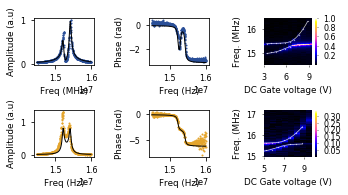

In [104]:
#Plots for paper

sns.set_context('paper')

m1_col = "#2A4F98"
m2_col = "#E4A52D"

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (5,2.7))

#subplotssty = {'figsize': (4,3), "constrained_layout":True} # constrained was bad!
subplotssty = {'figsize': (4,3)}

tickwidth = .5
cbarticklength = 1
plotticklength = 2


linesty = {'color':'white', 'linewidth':0.7, 'alpha': .8}
pointssty = {'color':'white', 'alpha': .6, 'marker': '.', 'markersize':2.5, 'linestyle': 'None', 'legend':False, }
cmap = 'gnuplot2'
cbarlabel = None
freqlabel = 'Freq. (MHz)'



ax1.plot(x1, y1, '.', markersize = 4, color = m1_col)
ax1.plot(x1, curve1(x1, k_2, k_12, m_2), '-', color='black', linewidth = 1)
ax1.set_xlabel('Freq (MHz)')
ax1.set_ylabel('Amplitude (a.u)')

ax2.plot(x1, th1, '.', markersize = 4, color = m1_col)
ax2.plot(x1, theta1(x1, k_2, k_12, m_2), '-', color='black', linewidth = 1)
ax2.set_xlabel('Freq (Hz)')
ax2.set_ylabel('Phase (rad)')

plt.sca(ax3)
dk = bigdrum_V['dk']
m1 = bigdrum_V['m1']
m2 = bigdrum_V['m2']
k = bigdrum_V['k']
k1 = bigdrum_V['k1']
_, cbar4 = myheatmap(bigdrum_V['heatmapdf'], cbarlabel, cmap = cmap, return_cbar=True)
bigdrum_V['datapoints'].plot(**pointssty, ax=ax3)
ylims = plt.ylim()
plt.ylabel(freqlabel)
plt.xlabel("DC Gate voltage (V)")
#print(file)
plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1),**linesty)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), **linesty)
plt.xlim(3,9.4)
#plt.ylim(bigdrum_V['ylims'])
#del m1,m2,k,k1,dk
plt.xticks([3,6,9])

ax4.plot(x2, y2, '.', markersize = 4, color = m2_col)
ax4.plot(x1, curve2(x2, k_2, k_12, m_2), '-', color='black', linewidth = 1)
ax4.set_xlabel('Freq (Hz)')
ax4.set_ylabel('Amplitude (a.u)')

ax5.plot(x2, th2, '.', markersize = 4, color = m2_col)
ax5.plot(x1, theta2(x2, k_2, k_12, m_2), '-', color='black', linewidth = 1)
ax5.set_xlabel('Freq (Hz)')
ax5.set_ylabel('Phase (rad)')


plt.sca(ax6)
dk = tinydrum_V['dk']
m1 = tinydrum_V['m1']
m2 = tinydrum_V['m2']
k = tinydrum_V['k']
k1 = tinydrum_V['k1']
_,cbar2 = myheatmap(tinydrum_V['heatmapdf'],cbarlabel, cmap = cmap, return_cbar=True)
tinydrum_V['datapoints'].plot(**pointssty, ax=ax6)
plt.ylabel(freqlabel)
plt.xlabel("DC Gate voltage (V)")
#plt.title(file + '\n')

plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1), **linesty)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), **linesty)

#plt.ylim(14.8, 16.2)
plt.xlim(tinydrum_V['xlims'])
plt.xticks(tinydrum_V['xticks'])

for ax in [ax3,ax6]:
    ax.tick_params(direction='out', length=plotticklength, width=tickwidth)

for cbar in [cbar2, cbar4]:
    cbar.ax.tick_params(length=cbarticklength, width=tickwidth)



plt.tight_layout()

fig.savefig('/Volumes/Aleman-Lab/Group/Papers and Abstracts/Coupled Resonator Spatial Imaging/Figures/python_exports/Figure2Curves.pdf', bbox_inches= 'tight', pad_inches=0.05)

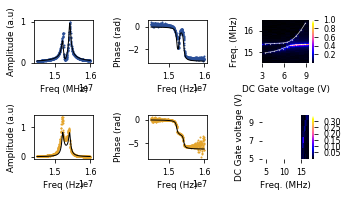

In [103]:
#Plots for paper

sns.set_context('paper')

m1_col = "#2A4F98"
m2_col = "#E4A52D"

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (5,2.7))

#subplotssty = {'figsize': (4,3), "constrained_layout":True} # constrained was bad!
subplotssty = {'figsize': (4,3)}

tickwidth = .5
cbarticklength = 1
plotticklength = 2


linesty = {'color':'white', 'linewidth':0.7, 'alpha': .8}
pointssty = {'color':'white', 'alpha': .6, 'marker': '.', 'markersize':2.5, 'linestyle': 'None', 'legend':False, }
cmap = 'gnuplot2'
cbarlabel = None
freqlabel = 'Freq. (MHz)'



ax1.plot(x1, y1, '.', markersize = 4, color = m1_col)
ax1.plot(x1, curve1(x1, k_2, k_12, m_2), '-', color='black', linewidth = 1)
ax1.set_xlabel('Freq (MHz)')
ax1.set_ylabel('Amplitude (a.u)')

ax2.plot(x1, th1, '.', markersize = 4, color = m1_col)
ax2.plot(x1, theta1(x1, k_2, k_12, m_2), '-', color='black', linewidth = 1)
ax2.set_xlabel('Freq (Hz)')
ax2.set_ylabel('Phase (rad)')

plt.sca(ax3)
dk = bigdrum_V['dk']
m1 = bigdrum_V['m1']
m2 = bigdrum_V['m2']
k = bigdrum_V['k']
k1 = bigdrum_V['k1']
_, cbar4 = myheatmap(bigdrum_V['heatmapdf'], cbarlabel, cmap = cmap, return_cbar=True)
bigdrum_V['datapoints'].plot(**pointssty, ax=ax3)
ylims = plt.ylim()
plt.ylabel(freqlabel)
plt.xlabel("DC Gate voltage (V)")
#print(file)
plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1),**linesty)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), **linesty)
plt.xlim(3,9.4)
#plt.ylim(bigdrum_V['ylims'])
#del m1,m2,k,k1,dk
plt.xticks([3,6,9])

ax4.plot(x2, y2, '.', markersize = 4, color = m2_col)
ax4.plot(x1, curve2(x2, k_2, k_12, m_2), '-', color='black', linewidth = 1)
ax4.set_xlabel('Freq (Hz)')
ax4.set_ylabel('Amplitude (a.u)')

ax5.plot(x2, th2, '.', markersize = 4, color = m2_col)
ax5.plot(x1, theta2(x2, k_2, k_12, m_2), '-', color='black', linewidth = 1)
ax5.set_xlabel('Freq (Hz)')
ax5.set_ylabel('Phase (rad)')


t = tinydrum_V['heatmapdf']

plt.sca(ax6)
dk = tinydrum_V['dk']
m1 = tinydrum_V['m1']
m2 = tinydrum_V['m2']
k = tinydrum_V['k']
k1 = tinydrum_V['k1']
_,cbar2 = myheatmap(t.transpose(),cbarlabel, cmap = cmap, return_cbar=True)
tinydrum_V['datapoints'].plot(**pointssty, ax=ax6)
plt.xlabel(freqlabel)
plt.ylabel("DC Gate voltage (V)")
#plt.title(file + '\n')

plt.plot(dk**.25,lowerantifn(dk, m1,m2,k,k1), **linesty)
plt.plot(dk**.25,upperantifn(dk, m1,m2,k,k1), **linesty)

#plt.ylim(14.8, 16.2)
plt.ylim(tinydrum_V['xlims'])
plt.yticks(tinydrum_V['xticks'])

plt.tight_layout()
